## Hackathon

In [157]:
import xarray as xr
import numpy as np
import pandas as pd
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from tqdm import tqdm



xr.set_options(display_style="text")

## Data loader om data uit de grote set te halen.

Gebruik `loader.get_subset()` voor specifieke ranges van tijd, longitude en latitude. 

Gebruik `subset.to_dataframe()` om een tabel van type xarray om te zetten naar een pandas dataframe. 

In [1]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pandas as pd
from matplotlib.animation import FuncAnimation, PillowWriter
import numpy as np

# ==== Parameters voor Europa ====
lat_min, lat_max = 34, 68
lon_min, lon_max = -25, 37.25

# === Controleer tijdsdimensie ===
time_dim = 'valid_time' if 'valid_time' in dataset['t2m'].dims else 'time'

# === Alle dagen van 2023 ===
days = pd.date_range("2023-01-01", "2023-12-31", freq="D")

# === Kleurenschaal ===
vmin, vmax = 260, 310

# === Coördinaten ===
lats = dataset.latitude.values
lons = dataset.longitude.values

# === Figuur met twee panelen: links boxplot, rechts kaart ===
fig = plt.figure(figsize=(16, 8))
gs = fig.add_gridspec(1, 2, width_ratios=[1, 2])
ax_box = fig.add_subplot(gs[0])  # boxplot links
ax_map = fig.add_subplot(gs[1], projection=ccrs.PlateCarree())  # kaart rechts

# === Kaart instellen ===
ax_map.set_extent([lon_min, lon_max, lat_min, lat_max])
ax_map.add_feature(cfeature.LAND, facecolor='lightgray')
ax_map.add_feature(cfeature.OCEAN, facecolor='lightblue')
ax_map.add_feature(cfeature.BORDERS, edgecolor='black')
ax_map.add_feature(cfeature.COASTLINE, edgecolor='black', linewidth=1.2)

# === Shapefile (optioneel) ===
if not geo_df_clipped.empty:
    geo_df_clipped.boundary.plot(ax=ax_map, color='darkred', linewidth=1.5, transform=ccrs.PlateCarree())

# === Eerste frame (dag 0) ===
data0 = dataset['t2m'].isel({time_dim: 0}).values
img = ax_map.imshow(
    data0,
    extent=(lons.min(), lons.max(), lats.min(), lats.max()),
    origin='lower',
    cmap='coolwarm',
    vmin=vmin, vmax=vmax,
    transform=ccrs.PlateCarree()
)
cbar = fig.colorbar(img, ax=ax_map, label='Temperatuur (K)', shrink=0.7, pad=0.02)

# === Eerste boxplot + gemiddelde ===
flat_data = data0.flatten()
mean_temp = np.nanmean(flat_data)

bp = ax_box.boxplot(flat_data, vert=True, patch_artist=True,
                    boxprops=dict(facecolor='lightcoral'))
ax_box.scatter(1, mean_temp, color='blue', zorder=3, s=60, label='Gemiddelde')
ax_box.set_ylim(vmin, vmax)
ax_box.set_ylabel("Temperatuur (K)")
ax_box.set_title("Verdeling temperatuur Europa")
ax_box.legend(loc='upper right')

# === Updatefunctie ===
def update(frame):
    date = days[frame]
    daily_data = dataset['t2m'].sel({time_dim: slice(date, date + pd.Timedelta(days=1))})
    
    # Dagelijkse gemiddelde kaart
    if time_dim in daily_data.dims:
        mean_t2m = daily_data.mean(dim=time_dim)
    else:
        mean_t2m = daily_data
    
    data_day = mean_t2m.values
    mean_temp = np.nanmean(data_day)

    # === Update kaart ===
    img.set_data(data_day)
    ax_map.set_title(f"Gemiddelde temperatuur {date.strftime('%d %B %Y')} (K)", fontsize=14, fontweight='bold')

    # === Update boxplot ===
    ax_box.cla()
    ax_box.boxplot(data_day.flatten(), vert=True, patch_artist=True,
                   boxprops=dict(facecolor='lightcoral'))
    ax_box.scatter(1, mean_temp, color='blue', zorder=3, s=60, label='Gemiddelde')
    ax_box.set_ylim(vmin, vmax)
    ax_box.set_ylabel("Temperatuur (K)")
    ax_box.set_title("Verdeling temperatuur Europa")
    ax_box.legend(loc='upper right')

# === Animatie ===
ani = FuncAnimation(fig, update, frames=len(days), interval=80, blit=False)
ani.save("temperatuur_2023_dagelijks_boxplot_mean.gif", writer=PillowWriter(fps=12))

plt.close(fig)

from matplotlib.animation import FFMpegWriter



NameError: name 'dataset' is not defined

In [63]:
class DataLoader:
    """Simple dataloader for NetCDF temperature data."""
    
    def __init__(self, file_path):
        self.file_path = file_path
        self.dataset = None
    
    def load_data(self):
        """Load and preprocess the dataset."""
        self.dataset = xr.open_dataset(self.file_path, engine="h5netcdf")
        
        # Fix coordinates
        if self.dataset["longitude"].max() > 180:
            self.dataset = self.dataset.assign_coords(
                longitude=(self.dataset["longitude"].values + 180) % 360 - 180
            )
        if self.dataset["latitude"].max() > 90:
            self.dataset = self.dataset.assign_coords(
                latitude=self.dataset["latitude"].values - 90
            )
        
        # Sort coordinates
        self.dataset = self.dataset.sortby(["latitude", "longitude"])
        return self.dataset
    
    def get_subset(self, time_range=None, lat_range=None, lon_range=None):
        """Get a subset of the data."""
        if self.dataset is None:
            raise ValueError("Load data first!")
        
        subset = self.dataset
        if time_range:
            subset = subset.sel(valid_time=slice(time_range[0], time_range[1]))
        if lat_range:
            subset = subset.sel(latitude=slice(lat_range[0], lat_range[1]))
        if lon_range:
            subset = subset.sel(longitude=slice(lon_range[0], lon_range[1]))
        
        return subset.compute()
    


In [127]:
# Example usage
loader = DataLoader("2023_2m_temperature.nc")
loader_clouds = DataLoader("clouds.nc")
dataset = loader.load_data()
dataset_clouds = loader_clouds.load_data()

In [ ]:
subset = loader.get_subset(
    time_range=("2023-05-01", "2023-05-31"),
    lat_range=(52.25, 52.25),
    lon_range=(5.0, 5.0)
)

In [66]:
# Convert to dataframe

subset_df = subset.to_dataframe().reset_index()
subset_df = subset_df.drop(['number', 'expver'], axis=1)
subset.to_dataframe()

mean_t2m = dataset['t2m'].sel(valid_time=slice("2023-05-01", "2023-05-31")).mean(dim='valid_time')

## Methode om je forecast functie te evalueren op een random steekproef van de dataset. 
In dit voorbeeld wordt steeds 2 weken historische data gepakt en wordt 1 week vooruit voorspeld.

`generate_eval_data()` geeft n random periodes van 3 weken op willekeurige locaties.

`forecast(history, n_points)` neemt een historische reeks van temperaturen en voorspelt de volgende n_points.

`forecast_1w()` evalueert de forecast functie op een random week (MAE score) en toont een grafiek van de historische reeks, de echte waardes en de voorspelde waarde. 

`evaluator(function, n_samples)` berekent de mean absolute error (MAE) van de voorspelling van functie `forecast()` voor een steekproef van grootte n_samples. 

In [67]:
def generate_eval_data(n = 100):
    rng = np.random.default_rng()
    
    # ---- Random geolocation ----
    # Longitude uniform in [-180, 180)
    lon = rng.uniform(-25, 37.25, n)
    lon = np.round(lon * 4)/4
    
    # Latitude area-uniform: sample z = sin(lat) ~ U(-1,1)  => lat = arcsin(z)
    lat = rng.uniform(34, 71.25, n)
    lat = np.round(lat * 4)/4
    
    # ---- Random 3-week interval in 2023 ----
    start0 = pd.Timestamp("2023-01-01")
    # Inclusive end = start + 20 days (21 calendar days total)
    last_start = pd.Timestamp("2023-12-31") - pd.Timedelta(days=20)
    num_choices = (last_start - start0).days + 1
    
    offsets = rng.integers(0, num_choices, n)  # days after Jan 1
    start_date = start0 + pd.to_timedelta(offsets, unit="D")
    end_date = start_date + pd.Timedelta(days=20)
    
    # ---- Assemble DataFrame ----
    df = pd.DataFrame({
        "latitude_deg": lat,
        "longitude_deg": lon,
        "start_date": start_date.strftime("%Y-%m-%d"),
        "end_date": end_date.strftime("%Y-%m-%d")
    })
    return df

In [68]:
def generate_eval_data_non_rand(lon, lat, start_date=['2023-05-01'], end_date=['2023-05-21']):
    # ---- Assemble DataFrame ----
    df = pd.DataFrame({
        "latitude_deg": lat,
        "longitude_deg": lon,
        "start_date": start_date,
        "end_date": end_date
    })
    return df

In [69]:
def sine_model(x, A, b, c, d):
    sin = A * np.sin(2*np.pi/c * (x+b)) + d
    return sin

In [70]:
def ARIMA_sine_fitted(history, lon = 40, lat = 25, start_date_hist = '2023-02-23', end_date_hist = '2023-03-08', n_points = 7*24):
    
    t = np.arange(len(history))

    guess = [10, 0, 24, np.mean(history)]  
    # limieten: [A1, b1, c1, d1]
    lower = [0, -24, 0, 0]
    upper = [20, 24, 25, 320]

    try:
        params, pcov = curve_fit(sine_model, np.arange(len(history)), history, p0=guess, bounds=(lower, upper))
        A, b, c, d= params

        d -= np.mean(history)
    except:
        A, b, c, d = [0.0, 0.0, 1.0, 0.0]

    y = sine_model(t, A, b, c, d)

    model = sm.tsa.ARIMA(history, order=(1, 0, 0)).fit()

    forecast = model.forecast(steps=n_points)

    x = np.arange(start=len(history), stop=len(history) + n_points)

    forecast_fitted = forecast + sine_model(x, A, b, c, d)

    delta = history[-1] - forecast_fitted[0]

    forecast_fitted += delta

    return forecast_fitted

In [71]:
def AR1(history, lon = 40, lat = 25, start_date_hist = '2023-02-23', end_date_hist = '2023-03-08', n_points = 7*24):
    mu = np.mean(history)
    sigma = np.std(history)

    X = [history[-1]]

    phi = .9

    for t in range(1, n_points):
        eps = np.random.normal(0, sigma)
        x_t = mu + phi * (X[-1] - mu) + eps * .1

        X.append(x_t)

    return X

In [72]:
def AR1_sine_fitted(history, lon = 40, lat = 25, start_date_hist = '2023-02-23', end_date_hist = '2023-03-08', n_points = 7*24):

    t = np.arange(len(history))

    guess = [10, 0, 24, np.mean(history)]  
    # limieten: [A1, b1, c1, d1]
    lower = [0, -24, 0, 0]
    upper = [20, 24, 25, 320]

    params, pcov = curve_fit(sine_model, np.arange(len(history)), history, p0=guess, bounds=(lower, upper))
    A, b, c, d= params

    d -= np.mean(history)

    y = sine_model(t, A, b, c, d)


    forecast = AR1(history, lon, lat, start_date_hist, end_date_hist)

    x = np.arange(start=len(history), stop=len(history) + n_points)
    forecast_fitted = forecast + sine_model(x, A, b, c, d)

    return forecast_fitted

In [73]:
def forecast(history, lon = 40, lat = 25, start_date_hist = '2023-02-23', end_date_hist = '2023-03-08', n_points = 7*24):
    # Take the last point of the history and repeat it n_points times
    try:
        return np.full(n_points, history[-1])
    except: 
        return np.full(n_points, 0)

def forecast_1w(row, function, operation = 'loop'):
    sample = loader.get_subset(
            time_range=(row['start_date'], row['end_date']),
            lat_range=(row['latitude_deg'], row['latitude_deg']),
            lon_range=(row['longitude_deg'], row['longitude_deg'])
        ).compute()
    history = sample.sel(valid_time=slice(row['start_date'],(pd.to_datetime(row['start_date']) + pd.Timedelta(weeks=2)).strftime("%Y-%m-%d")))['t2m'].data.flatten()
    y_true = sample.sel(valid_time=slice((pd.to_datetime(row['start_date']) + pd.Timedelta(weeks=2)).strftime("%Y-%m-%d"),row['end_date']))['t2m'].data.flatten()
    y_pred = function(history, 
                      row['longitude_deg'], 
                      row['latitude_deg'], 
                      row['start_date'],
                      (pd.to_datetime(row['start_date']) + pd.Timedelta(weeks=2)).strftime("%Y-%m-%d"), 
                      len(y_true))
    if operation == 'manual':
        fig, ax = plt.subplots()
        ax.plot(range(len(history)), history, color = 'blue')
        ax.plot(range(len(history), len(history) + len(y_true)), y_true, color = 'blue', linestyle = 'dashed')
        ax.plot(range(len(history), len(history) + len(y_true)), y_pred, color = 'green', linestyle = (0, (1, 1)))
    return np.mean(np.abs(y_true - y_pred))

In [74]:
def evaluator(function, n_samples = 100):
    errors = []
    df = generate_eval_data(n_samples)
    for index, row in df.iterrows():
        error = forecast_1w(row, function, operation = 'loop')
        errors.append(error)
    return np.mean(errors)

In [75]:
evaluator(forecast, 250)

np.float32(2.5314262)

In [ ]:
# Generate error map

error_df_ARIMA_UPDATED = pd.DataFrame(columns=['lon', 'lat', 'error'])

high_error = []

for lat in range(3400, 7150, 25):
    for lon in range(-2500, 3750, 25):
        df = generate_eval_data_non_rand(lon / 100, lat/ 100)
        error= forecast_1w(df.iloc[0], ARIMA_sine_fitted, operation = 'loop')
        error_df_ARIMA_UPDATED.loc[len(error_df_ARIMA_UPDATED)] = [lon / 100, lat / 100, error]

        if np.mean(error) > 7.0:
            lon_lat = [lon / 100, lat / 100]
            high_error.append(lon_lat)



"# Generate error map\n\nerror_df_ARIMA_UPDATED = pd.DataFrame(columns=['lon', 'lat', 'error'])\n\nhigh_error = []\n\nfor lat in range(3400, 7150, 25):\n    for lon in range(-2500, 3750, 25):\n        df = generate_eval_data_non_rand(lon / 100, lat/ 100)\n        error= forecast_1w(df.iloc[0], ARIMA_sine_fitted, operation = 'loop')\n        error_df_ARIMA_UPDATED.loc[len(error_df_ARIMA_UPDATED)] = [lon / 100, lat / 100, error]\n\n        if np.mean(error) > 7.0:\n            lon_lat = [lon / 100, lat / 100]\n            high_error.append(lon_lat)\n"

In [77]:
error_df_ARIMA_UPDATED = pd.read_csv('ARIMA_error.csv', index_col='Unnamed: 0')

In [78]:
print(error_df_ARIMA_UPDATED['error'].mean())

2.1587987752946582


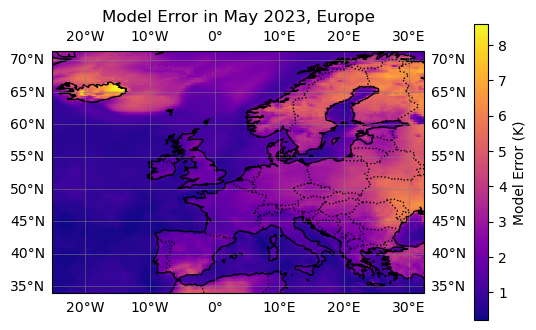

In [79]:
# Vind unieke waarden
lons = np.sort(error_df_ARIMA_UPDATED['lon'].unique())
lats = np.sort(error_df_ARIMA_UPDATED['lat'].unique())

# Reshape error naar 2D-array
error_grid = error_df_ARIMA_UPDATED['error'].values.reshape(len(lats), len(lons))


# Maak meshgrid
LON, LAT = np.meshgrid(lons, lats)

# Plot
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})

# Inverted cmap + manual scale
#vmin, vmax = 0.21303982325127824, 9.697968226707493  # 👈 adjust manually as needed
pcm = ax.pcolormesh(
    LON,
    LAT,
    error_grid,
    cmap='plasma',
    shading='auto'
)

ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.COASTLINE)

gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False,
                  linewidth=0.5, color='gray', alpha=0.7)

cbar = fig.colorbar(pcm, ax=ax, orientation='vertical', pad=0.1, shrink=0.8)
cbar.set_label('Model Error (K)')

ax.set_title('Model Error in May 2023, Europe')
plt.show()


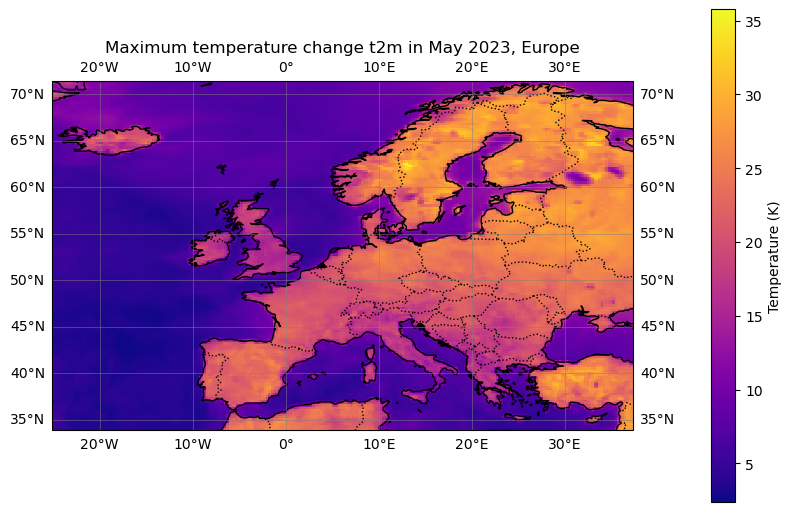

In [80]:
# Task 1
lats = np.linspace(34, 71.25, 150)
lons = np.linspace(-25, 37.25, 250)

LON, LAT = np.meshgrid(lons, lats)

t2m_values = loader.get_subset(
    time_range=("2023-05-01", "2023-05-31"),
    lat_range=(34, 71.25),
    lon_range=(-25, 37.25)
)

monthly_mean = t2m_values['t2m'].max(dim='valid_time').values - t2m_values['t2m'].min(dim='valid_time').values

coords = np.stack([LAT, LON], axis=-1)

fig, ax = plt.subplots(figsize=(10, 8), subplot_kw={'projection': ccrs.PlateCarree()})

pcm = ax.pcolormesh(
    LON, LAT, monthly_mean,
    cmap='plasma',
    shading='auto'
)


ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.COASTLINE)

gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False,
                  linewidth=0.5, color='gray', alpha=0.7)

cbar = fig.colorbar(pcm, ax=ax, orientation='vertical', pad=0.1, shrink=0.8)
cbar.set_label('Temperature (K)')

ax.set_title('Maximum temperature change t2m in May 2023, Europe')
plt.show()


In [151]:
class TemperatureForecaster:
    def __init__(self, loader, loader_clouds=None, history_hours=72, forecast_hours=24, n_estimators=200, max_depth=20, random_state=42):
        self.loader = loader
        self.loader_clouds = loader_clouds     
        self.history_hours = history_hours
        self.forecast_hours = forecast_hours
        self.model = RandomForestRegressor(
            n_estimators=n_estimators,
            max_depth=max_depth,
            n_jobs=-1,
            random_state=random_state
        )
        self.trained = False

    # --- Zorg dat history altijd juiste lengte heeft ---
    def pad_history(self, history):
        history = np.array(history)
        if len(history) == 0:
            history = np.zeros(self.history_hours)
        elif len(history) < self.history_hours:
            history = np.concatenate([np.full(self.history_hours - len(history), history[0]), history])
        return history[-self.history_hours:]

    # --- Zet een trainingssample om naar featurevector ---
    def build_features_from_sample(self, row):
        # --- Haal t2m history ---
        subset_t2m = self.loader.get_subset(
            time_range=(pd.to_datetime(row['start_date']) - pd.Timedelta(hours=self.history_hours),
                        row['start_date']),
            lat_range=(row['latitude_deg'], row['latitude_deg']),
            lon_range=(row['longitude_deg'], row['longitude_deg'])
        ).compute()

        history_t2m = subset_t2m.sel(
            latitude=row['latitude_deg'],
            longitude=row['longitude_deg'],
            method='nearest'
        )['t2m'].data.flatten()
        history_t2m = self.pad_history(history_t2m)

        # --- Haal cloud history ---
        subset_cloud = self.loader_clouds.get_subset(
            time_range=(pd.to_datetime(row['start_date']) - pd.Timedelta(hours=self.history_hours),
                        row['start_date']),
            lat_range=(row['latitude_deg'], row['latitude_deg']),
            lon_range=(row['longitude_deg'], row['longitude_deg'])
        ).compute()

        history_lcc = subset_cloud.sel(
            latitude=row['latitude_deg'],
            longitude=row['longitude_deg'],
            method='nearest'
        )['lcc'].data.flatten()
        history_lcc = self.pad_history(history_lcc)

        # --- Tijd en locatie ---
        start_time = pd.to_datetime(row['start_date'])
        hour_of_day = start_time.hour / 23
        day_of_year = start_time.dayofyear / 365

        # --- Combineer features ---
        X = np.concatenate([
            history_t2m,     # t2m history
            history_lcc,     # cloud history
            [row['latitude_deg'], row['longitude_deg'], hour_of_day, day_of_year]
        ])
        return X

    # --- Bereid trainingsdata voor ---
    def prepare_training_data(self, df_samples):
        X_list, y_list = [], []
        
        for _, row in df_samples.iterrows():
            # --- Maak featurevector inclusief clouds ---
            X_list.append(self.build_features_from_sample(row))

            # --- Haal echte temperaturen op voor target ---
            subset_t2m = self.loader.get_subset(
                time_range=(row['start_date'], row['end_date']),
                lat_range=(row['latitude_deg'], row['latitude_deg']),
                lon_range=(row['longitude_deg'], row['longitude_deg'])
            ).compute()

            y = subset_t2m.sel(
                latitude=row['latitude_deg'],
                longitude=row['longitude_deg'],
                method='nearest'
            )['t2m'].data.flatten()

            y_list.append(y)

        # --- Zet om naar numpy arrays ---
        X = np.array(X_list)
        y = np.array(y_list)

        n_hours = y.shape[1]

        # --- Flatten voor RandomForest ---
        X_flat = np.repeat(X, n_hours, axis=0)
        y_flat = y.reshape(-1)

        return X_flat, y_flat


    # --- Train het model ---
    def fit(self, df_samples):
        X_flat, y_flat = self.prepare_training_data(df_samples)
        self.model.fit(X_flat, y_flat)
        self.trained = True

    # --- Voorspel temperatuur voor een specifieke locatie en starttijd ---
    def predict_point(self, lat, lon, date, n_hours=None):
        if not self.trained:
            raise ValueError("Model moet getraind zijn voordat je kunt voorspellen.")
        if n_hours is None:
            n_hours = self.forecast_hours

        # --- Haal histories op ---
        subset_t2m = self.loader.get_subset(
            time_range=(date - pd.Timedelta(hours=self.history_hours), date),
            lat_range=(lat, lat),
            lon_range=(lon, lon)
        ).compute()
        history_t2m = subset_t2m.sel(latitude=lat, longitude=lon, method="nearest")["t2m"].data.flatten()
        history_t2m = self.pad_history(history_t2m)

        subset_cloud = self.loader_clouds.get_subset(
            time_range=(date - pd.Timedelta(hours=self.history_hours), date),
            lat_range=(lat, lat),
            lon_range=(lon, lon)
        ).compute()
        history_lcc = subset_cloud.sel(latitude=lat, longitude=lon, method="nearest")["lcc"].data.flatten()
        history_lcc = self.pad_history(history_lcc)

        preds = []
        for t in range(n_hours):
            current_time = date + pd.Timedelta(hours=t)
            hour_of_day = current_time.hour / 23
            day_of_year = current_time.dayofyear / 365

            x = np.concatenate([
                history_t2m[-self.history_hours:],  # t2m history
                history_lcc[-self.history_hours:],  # cloud history
                [lat, lon, hour_of_day, day_of_year]
            ]).reshape(1, -1)

            next_temp = self.model.predict(x)[0]
            preds.append(next_temp)

            # Update histories autoregressief
            history_t2m = np.append(history_t2m, next_temp)
            history_lcc = np.append(history_lcc, history_lcc[-1])  # gebruik laatste lcc als proxy

        return np.array(preds)


In [ ]:
# Maak het aantal samples voor de evaluatie
df_samples = generate_eval_data(5000)

# Initialiseer en zet de forecast op een dag (24 stappen)
forecaster = TemperatureForecaster(loader, loader_clouds=loader_clouds, history_hours=72, forecast_hours=24)

# Train het ML model
forecaster.fit(df_samples)

In [155]:
# Voor heel Europa (globale ranges, kan verfijnd)
lat_min, lat_max = 34.0, 72.0  
lon_min, lon_max = -25.0, 40.0

subset_clouds = loader_clouds.get_subset(
    time_range=("2023-05-01", "2023-05-31"),
    lat_range=(lat_min, lat_max),
    lon_range=(lon_min, lon_max)
)

# Kies de coordinaten om de MAE van te voorspellen
lat, lon = 55, 20

subset = loader.get_subset(
    time_range=("2023-05-15", "2023-05-16"),
    lat_range=(lat, lat),
    lon_range=(lon, lon)
)
# Pak de werkelijke t2m van de hierboven gekozen locatie en tijd
t2m_true = subset.sel(
    latitude=lat,
    longitude=lon,
    method="nearest"
)["t2m"].data.flatten()

# Check de lengte: moet gelijk zijn aan n_hours (24)
t2m_true = t2m_true[:24]

date = pd.Timestamp("2023-05-15 00:00")

preds = forecaster.predict_point(lat=lat, lon=lon, date=date, n_hours=24)

# Bereken statistieken
true_mean = t2m_true.mean()
pred_mean = preds.mean()
mae = np.mean(np.abs(preds - t2m_true))

print(f"Gemiddelde werkelijke temperatuur: {true_mean:.2f} K")
print(f"Gemiddelde voorspelde temperatuur: {pred_mean:.2f} K")
print(f"Mean Absolute Error (MAE): {mae:.2f} K")




Gemiddelde werkelijke temperatuur: 287.94 K
Gemiddelde voorspelde temperatuur: 289.39 K
Mean Absolute Error (MAE): 2.87 K
